# RAPIDS: cuGraph Tutorial

In this tutorial, I will be going through an example using both cuGraph and Networkx to run a Pagerank implementation. Pagerank is used to quantify the importance of a vertex based on the ralative importance of it's neighbours. Thanks to Pagerank the connectivity information of a graph can be ranked assigned a certain importance to each of the different vertex.

As additional resources:
- https://github.com/rapidsai/notebooks/tree/branch-0.9/cugraph
- https://networkx.github.io/documentation/stable/tutorial.html
- https://pyvis.readthedocs.io/en/latest/tutorial.html


### Preprocessing

In [2]:
!nvidia-smi

Sat Jul 20 20:12:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!wget https://github.com/randerzander/notebooks-extended/raw/master/utils/rapids-colab.sh
!chmod +x rapids-colab.sh
!./rapids-colab.sh

import sys, os
sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

--2019-07-20 20:12:06--  https://github.com/randerzander/notebooks-extended/raw/master/utils/rapids-colab.sh
Resolving github.com (github.com)... 13.229.188.59
Connecting to github.com (github.com)|13.229.188.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/randerzander/notebooks-extended/master/utils/rapids-colab.sh [following]
--2019-07-20 20:12:06--  https://raw.githubusercontent.com/randerzander/notebooks-extended/master/utils/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1548 (1.5K) [text/plain]
Saving to: ‘rapids-colab.sh’

rapids-colab.sh     100%[===================>]   1.51K  --.-KB/s    in 0s      

2019-07-20 20:12:07 (173 MB/s) - ‘rapids-colab.sh’ saved [1548/1548]

-

In [4]:
# The notebook compares cuGraph to NetworkX,  
# therefore there some additional non-RAPIDS python libraries need to be installed. 
# Please run this cell if you need the additional libraries
!pip install networkx
!pip install scipy

     |████████████████████████████████| 1.8MB 49.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx


In [58]:
!pip install pyvis

     |████████████████████████████████| 757kB 27.0MB/s 
     |████████████████████████████████| 61kB 27.0MB/s 
     |████████████████████████████████| 890kB 45.2MB/s 
     |████████████████████████████████| 245kB 48.5MB/s 
     |████████████████████████████████| 81kB 30.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/a9/28/53/f24776b4c5bcbe91aaf1f1e247bd6fadd17191aa12fac63902
Successfully built simplegeneric


In [0]:
# Data available here: https://raw.githubusercontent.com/rapidsai/notebooks/branch-0.8/cugraph/data/karate-data.csv
datafile='/content/karate-data.csv'

# Read the data, this also created a NetworkX Graph 
file = open(datafile, 'rb')

### cuGraph

In [0]:
# Import needed libraries
import cudf
import cugraph
import numpy as np
from collections import OrderedDict

In [0]:
columns = ["source", "destination"]

dtypes = OrderedDict([
        ("source", "int32"), 
        ("destination", "int32")
        ])

df = cudf.read_csv(datafile, names=columns, delimiter='\t', dtype=list(dtypes.values()))

In [0]:
# create a Graph using the source and destination vertex pairs from the Dataframe 
G = cugraph.Graph()
G.add_edge_list(df["source"], df["destination"])

In [0]:
# Call cugraph.pagerank to get the pagerank scores
df_page = cugraph.pagerank(G)

In [25]:
# Find the most important vertex using the scores
bestScore = df_page['pagerank'][0]
bestVert = df_page['vertex'][0]

for i in range(len(df_page)):
    if df_page['pagerank'][i] > bestScore:
        bestScore = df_page['pagerank'][i]
        bestVert = df_page['vertex'][i]
        
print("Best vertex is " + str(bestVert) + " with score of " + str(bestScore))

Best vertex is 34 with score of 0.10047409


In [29]:
sort_pr = df_page.sort_values('pagerank', ascending=False)
sort_pr.head().to_pandas()

,vertex,pagerank
34,34,0.100474
1,1,0.096573
33,33,0.071377
3,3,0.056828
2,2,0.052645


In [30]:
# divide the degree by two since this is an undirected graph
d = G.degree()
d['degree'] = d['degree'] / 2
d.sort_values('degree', ascending=False).head().to_pandas()

,vertex,degree
34,34,17.0
1,1,16.0
33,33,12.0
3,3,10.0
2,2,9.0


### Networkx

In [0]:
import networkx as nx
from scipy.io import mmread
import pandas as pd
import matplotlib.pyplot as plt
import operator
from pyvis import network as net
import IPython

In [0]:
nxg = nx.read_edgelist(file)

In [93]:
# defining the parameters for nx pagerank method: maximum number of iterations, tolerance and alpha
pr_nx = nx.pagerank(nxg, alpha= 0.85, max_iter= 100, tol= 0.00001)

sorted_x = sorted(pr_nx.items(), key=operator.itemgetter(1), reverse=True)
df2 = pd.DataFrame.from_dict(sorted_x)
df2.columns = ["vertex", "pagerank"]
df2.head()

,vertex,pagerank
0,34,0.100924
1,1,0.097016
2,33,0.071696
3,3,0.057078
4,2,0.052884


By looking at the following graph we can notice that the top scoring vertices corresponds to the vertices with the most connections (confirming our expectations).

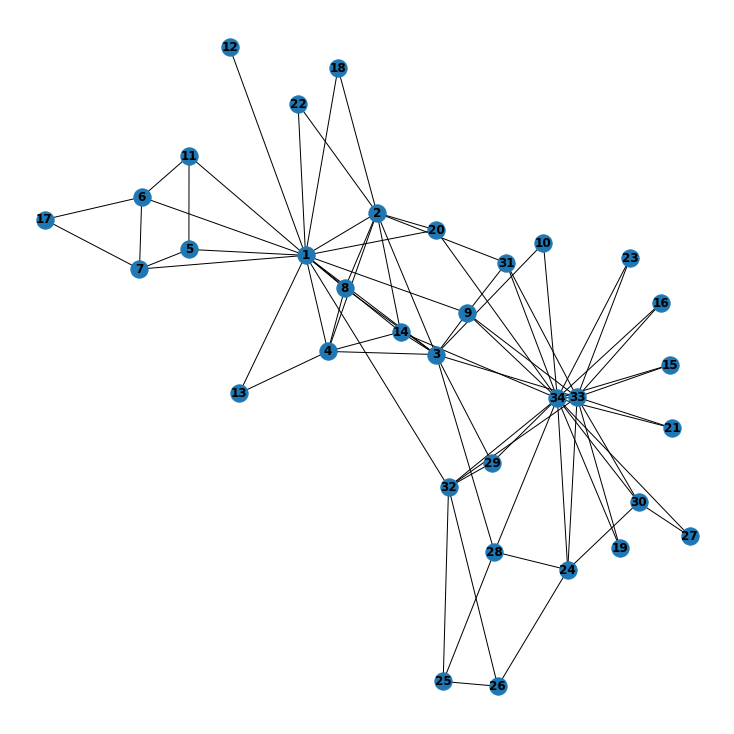

In [94]:
plt.figure(figsize=(10,10))
nx.draw(nxg, with_labels=True, font_weight='bold')

In [95]:
# Making the graph interactive

g = net.Network(notebook=True)
g.from_nx(nxg)
g.show("KarateData.html")

IPython.display.HTML(filename="KarateData.html")